# The problem
Predict the hourly production of all the French power units. A power unit is the underlying physical electric generator housed in power plants. One power plant generally has more than one power unit : for example the Gravelines nuclear power plant in france has 6 power units. 
* 157 units, with different technologies: nuclear, gas...
* the data to predict consists in time series of length 13152 for every one of these 157 units
* the test set is in direct continuity to the data you have at your disposal in the train set (the complete timeseries correspond to >>> np.concatenate((train,test))

Project manager: Alexis Bergès
Email: ws@wattstrat.com ; we will try to answer any questions that you will send us. Every question answered in such a manner will be published along with our answer on the following webpage : www.wattstrat.com/datachallenge (at the time of writing, this url returns a 404, there are no questions to publish yet)
Type of project: Prediction

# Why this project?
We have already a good model for the national production of these different technologies, but having a picture at the production unit level is interesting both on a scientific level, and on a more philosophical one.

**Scientifically** the dataset is rich and clean (8760 hours per year), and the problem is challenging as the choice of which unit produces which amount every hour is dictated by the availability of a unit, the national demand for electricity, the interconnected countries’ demand, the renewable production, the geographical position of the unit, the regional demand for electricity, its level of production in the past hour, and the expected demand in the coming hours (non-exhaustive list :-)).

**Intellectually** this is interesting because how the electric mix is actually built hourly is what drives the carbon intensity that any electric consumption entails. For example, recovering the relative effects of national vs local demand for electricity for a unit can help to shed light on very important questions such as where to install a new plant, or how would the load of other plants be affected if one existing plant is removed, and therefore how would the CO2 emissions evolve.

# Description of the data
There are 3 files:
* categorical_input.csv : categorical data on the power units
* input_train.csv : input time series
* output_train.csv : output time series

Overall, as per the requirements of the challenge organizer, we have massaged the data so as to avoid any easy to implement cheating. That is to say that:
* the names of the units are random strings of length 10
* they are organised by geographical regions but that these region names are themselves random strings of length 10
* the timestamp of the timeseries is given by the first column of the csv as an index
* all the values are renormalized by a value that is not given to you

However we do not obfuscate:
* the type of technology of the power unit
* the full name of the input variables 
* the data corresponding to the whole of France is labelled as such (to avoid a double sum)

The reason for this is that we think it is simply both more interesting for the teams to know what they are working with, even if the actual values are rescaled so as to avoid cheating, and easier to think critically about the data if it still holds some meaning. 

## Input data
### categorical_input.json
This file holds a list which, for every power unit, gives the maximal theoretical hourly production and the technology for each unit, as well as its region of belonging. It is described explicitly below:

In [9]:
import csv
with open('categorical_input.csv','r') as f:
    myreader = csv.reader(f)
    categ_input = {}
    for idx,row in enumerate(myreader):
        if idx ==0:
            header = {subidx+1:el for subidx,el in enumerate(row[1:])}
        else:
            categ_input[row[0]] = {val:row[key] for key,val in header.items()}
units = list(categ_input.keys())
set_techno = set(el['techno'] for el in categ_input.values())
print('There are %s units'%(len(categ_input)))
print('One such unit is %s : %s' %(units[0],categ_input[units[0]]))
print('The set of technologies is %s' %(set_techno))

There are 157 units
One such unit is 20826ab3e5 : {'techno': 'Natural gas', 'region': '17e0e6c0d6', 'max capacity': '0.0014444444444444444'}
The set of technologies is {'Natural gas', 'Oil', 'Coal', 'Nuclear', 'Pumped-storage hydroelectricity', 'Other', 'Lakes hydroelectricity'}


### input_train.csv

In [17]:
import numpy as np
with open('input_train.csv','r') as f:
    myreader = csv.reader(f)
    input_train = []
    for idx,row in enumerate(myreader):
        if idx ==0:
            #do not take first column i.e. ID into account
            header_input_train = row[1:]
        else:
            #do not take first column i.e. ID into account
            input_train.append([float(el) for el in row[1:]])
    input_train = np.array(input_train)
print(input_train.shape)
print(header_input_train[:10])
    
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14,5.5]

import matplotlib.pyplot as plt
# import seaborn as sns

(13152, 200)
['I_cada9f758d_Solar PV', 'A_cada9f758d_54990be7a5', 'I_cada9f758d_Wind', 'I_cada9f758d_Demand', 'I_17e0e6c0d6_Solar PV', 'A_17e0e6c0d6_628ab6708a', 'A_17e0e6c0d6_336e1b51f8', 'A_17e0e6c0d6_fa3883184f', 'A_17e0e6c0d6_0bb32fbeea', 'A_17e0e6c0d6_a5f90057d9']


This file holds a list containing the input time series for 12 regions, and one at the level of France as a whole.

There are two types of data. First, proper inputs, labelled as 'I_region_varname' where region stands for the label of the region to which corresponds the data, and varname the variable name of the data (demand for electricity, interconnexions with other countries, wind production, solar production). We also have one such input at the level of France (the data does not exist at the regional level) for the run of the river hydroelectric production. Second, availability constraints, labelled as 'A_region_unit', where region stands for the region of the relevant unit of production, and unit stands for the name of the unit. This constraint is the maximal hourly production for a given unit, with the minimal production being 0 in the case of all technologies, except for the technology Pumped-storage hydroelectricity, which has the possibility to pump water up a dam, for which the minimum is therefore minus the maximum.

In more detail, for France as whole : 
* **Run of the river hydroelectricity**: The total hourly production of electricity from run of the river hydroelectric power plants, that is turbines simply put in rivers, without lakes or dams, only available at the level of France.

For every region, there are 5 big classes of time series:
* **I_region_Demand**: The total hourly demand for electricity in a given region.
* **I_region_Wind**: The total hourly production of electricity from wind turbines in a given region.
* **I_region_Solar PV**: The total hourly production of electricity from photovoltaic panels in a given region.
* **I_region_Interconnexion**: The international hourly exchanges of electricity for a given region: not all regions are interconnected with outside countries, 6 regions out of 12 are interconnected. It is considered as an additional production, that is when it is positive it means that the region is importing, and when it is negative it means that the region is exporting. The relevant regions have therefore a time series corresponding to this specific interconnexion.
* **A_region_unit**: corresponds to availability of a power unit installed in the given region, i.e. the time series of the power available at a given hour.
    * a power plant needs to be worked on and is therefore taken offline periodically
    * a power plant can sometimes face an unplanned failure
    * all of these events have been aggregated to give the corresponding hourly maximal production, which is always inferior or equal to the maximal theoretical hourly production fiven in categorical_input.json 
    * for all but one technology, the production of a given unit obeys the following relationship: $$0\leq P_i(t)\leq Dispo_i(t)$$
    * in the case of Pumped-storage hydroelectricity, the unit can pump water, thus consuming energy, to store it in a higher lake, therefore: $$ -Dispo_i(t)\leq P_i(t)\leq Dispo_i(t)$$

Below a plot of the total demand for electricity for region 'cada9f758d', one for the production of solar/wind, and a second for those three variables but zoomed in so as to illustrate the high frequency dynamics. As can be seen in the first graph there is an outlier around hour 8000. 

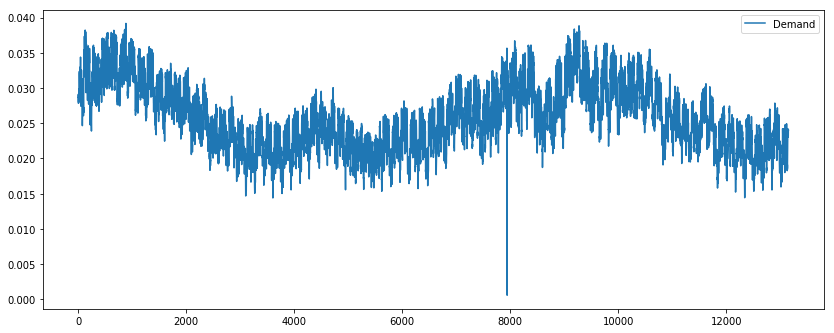

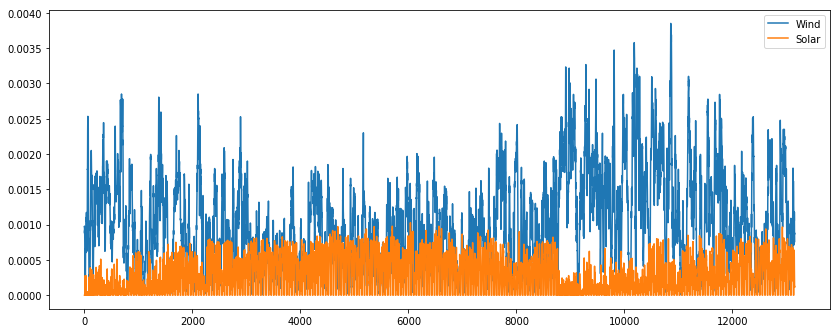

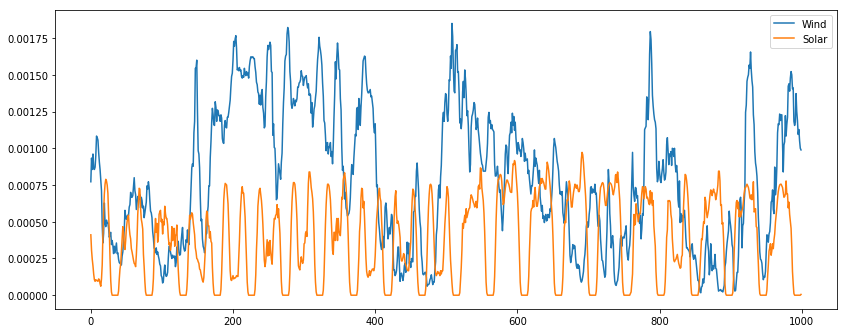

In [22]:
plt.plot(input_train[:,header_input_train.index('I_cada9f758d_Demand')], label='Demand')
plt.legend()
plt.show()

plt.plot(input_train[:,header_input_train.index('I_cada9f758d_Wind')], label='Wind')
plt.plot(input_train[:,header_input_train.index('I_cada9f758d_Solar PV')], label='Solar')
plt.legend()
plt.show()

idxi=4000
idxf=5000
plt.plot(input_train[:,header_input_train.index('I_cada9f758d_Wind')][idxi:idxf], label='Wind')
plt.plot(input_train[:,header_input_train.index('I_cada9f758d_Solar PV')][idxi:idxf], label='Solar')
plt.legend()
plt.show()

Some regions don't have any power unit, some have a lot.  Below is the graph of one such availability curve. 

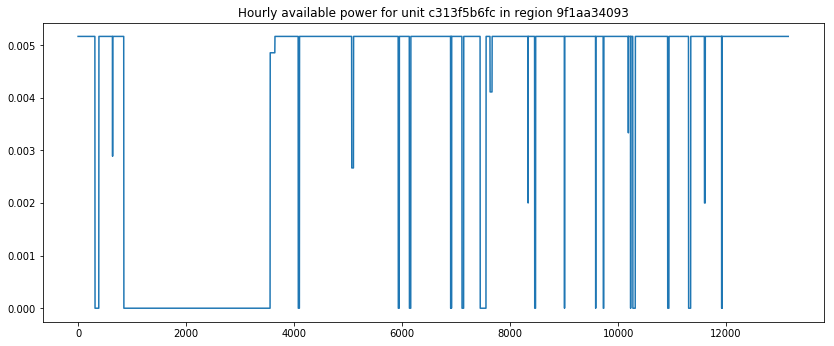

In [24]:
one_avail = 'A_9f1aa34093_c313f5b6fc'.split('_')
plt.plot(input_train[:,header_input_train.index('A_9f1aa34093_c313f5b6fc')])
plt.title('Hourly available power for unit %s in region %s'%(one_avail[2],one_avail[1]))
plt.show()


## Output data
### output_train.json

In [25]:
with open('output_train.csv','r') as f:
    myreader = csv.reader(f)
    output_train = []
    for idx,row in enumerate(myreader):
        if idx ==0:
            #do not take first column i.e. ID into account
            header_output_train = row[1:]
        else:
            #do not take first column i.e. ID into account
            output_train.append([float(el) for el in row[1:]])
    output_train = np.array(output_train)
print(output_train.shape)

(13152, 157)



This file contains the time series of production at the unit level, labelled as 'P_unit', where unit stands for the name of the relevant unit. One can note that there are some (rare) instances of the production of a unit being above its maximal theoretical value, and some (less rare, but still rare) instances of the production of a unit being above its availability time series. 

We can plot one observed production at the same time as its availability first for a random unit, then for a pump-storage unit, in order to contrast their two different behaviors (lower bound of $0$ and $-Dispo_i(t)$ respectively).

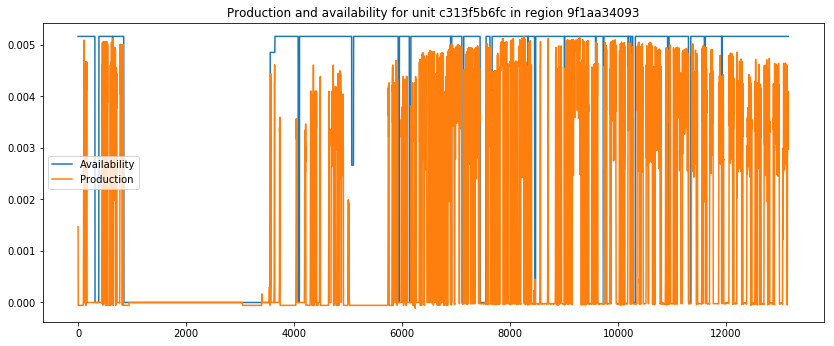

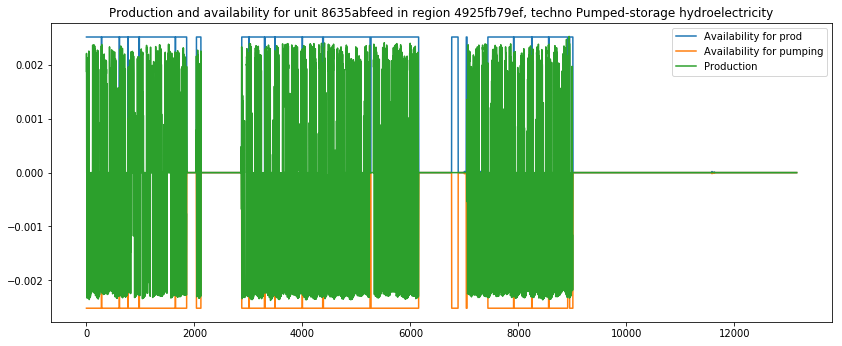

In [30]:
plt.plot(input_train[:,header_input_train.index('A_9f1aa34093_c313f5b6fc')], label='Availability')
plt.plot(output_train[:,header_output_train.index('P_'+one_avail[2])], label='Production')
plt.title('Production and availability for unit %s in region %s'%(one_avail[2],one_avail[1]))
plt.legend()
plt.show()

for unit in categ_input:
    if categ_input[unit]['techno'] == 'Pumped-storage hydroelectricity':
        break
region = categ_input[unit]['region']
myA = 'A_' + region + '_' + unit
myP = 'P_' + unit
plt.plot(input_train[:,header_input_train.index(myA)], label='Availability for prod')
plt.plot(-input_train[:,header_input_train.index(myA)], label='Availability for pumping')
plt.plot(output_train[:,header_output_train.index(myP)], label='Production')
plt.title('Production and availability for unit %s in region %s, techno %s'%(unit,region, categ_input[unit]['techno']))
plt.legend()
plt.show()

# Definition of the problem
**The input data**

For the sake of clarity, separate the availability data from the other data

In [42]:
#define a reproducible order of the different regions, units, and variables
subidx_inputs = [idx for idx, el in enumerate(header_input_train) if 'I_' in el]
subidx_avail = [idx for idx, el in enumerate(header_input_train) if 'A_' in el]
orderunit_avail = [header_output_train.index('P_' + el.split('_')[2]) for el in header_input_train if 'A_' in el]

x = input_train[:,subidx_inputs]
x_avail = input_train[:,subidx_avail]
y = output_train[:,orderunit_avail]
print('Shapes. x :', x.shape, 'x_avail :',x_avail.shape, 'y :', y.shape)


Shapes. x : (13152, 43) x_avail : (13152, 157) y : (13152, 157)


Define $\textbf{x}$ as the array of inputs for every region, and for France's hydro time series. It has for shape (13152, 43). 

Define $\textbf{x}_{avail}$ as the array of availability for every unit. It has for shape (13152, 157).

Define $\textbf{y}$ as the target array of production for every unit. It has for shape (13152, 157).

**Goal**

Find $f$ such that $f(\textbf{x},\textbf{x}_{avail})\mapsto \textbf{y}$. In practice the approximate function $\tilde{f}$, for which $\tilde{f}(\textbf{x},\textbf{x}_{avail}) = \tilde{\textbf{y}}$, has to verify the pointwise constraint that 
$$\delta_{pump} \odot \textbf{x}_{avail} \leq \textbf{y} \leq \textbf{x}_{avail} $$
with $\odot$ the elementwise multiplication of arrays and $\delta_{pump}$ an array of the same shape than x_avail which takes a value 0 if the point does not belong to a pump-storage hydroelectric unit, and -1 if it does.

Obviously, use the categorical data to your advantage, I don't know how to symbolise it clearly above.

It can be a good idea to use the output of the previous timestep as an input for the next one, as well as a window "seing" a few hours into the future, i.e. $\tilde{f}(x(t), x_{avail}(t), \tilde{y}(t-1), x(t+w), x_{avail}(t+w)) = \tilde{y}(t)$, to capture inertial and anticipation effects respectively.

# Metric
L2 norm of the production as a fraction of the theoretical maximal level of production
$$\frac{1}{U}\sum_{u=0}^{U-1}\frac{1}{N}\sum_{t=0}^{N-1} \left(\frac{y_u(t)-\tilde{y}_u(t)}{K_{max,u}}\right)^2$$
with 
* $U$ the number of units, $u$ one unit
* $N$ the number of hours, $t$ one such hour
* $y_u(t)$ the observed production for unit $u$ at time $t$
* $\tilde{y}_u(t)$ the predicted production for unit $u$ at time $t$
* $K_{max,u}$ the maximal theoretical production by unit $u$


# Benchmark

Take the residual demand, and dispatch it to all units so that every unit produces the fraction of its available capacity with respect to the total available capacity at a given time.


In [43]:
#residual demand 
demand_indices = [idx for idx, el in enumerate(header_input_train) if 'Demand' in el]
wind_indices = [idx for idx, el in enumerate(header_input_train) if 'Wind' in el]
solar_indices = [idx for idx, el in enumerate(header_input_train) if 'Solar PV' in el]
interco_indices = [idx for idx, el in enumerate(header_input_train) if 'Interconnexion' in el]
hydro_indices = [idx for idx, el in enumerate(header_input_train) if 'Run of the river hydroelectricity' in el]
print(len(demand_indices),len(wind_indices),len(solar_indices),len(interco_indices),len(hydro_indices))

dem = input_train[:,demand_indices].sum(axis=1)
wind = input_train[:,wind_indices].sum(axis=1)
pv = input_train[:,solar_indices].sum(axis=1)
interco = input_train[:,interco_indices].sum(axis=1)
hydro = input_train[:,hydro_indices].sum(axis=1)
res_dem = np.expand_dims(dem - wind - pv - hydro - interco,axis=1)
print(res_dem.shape)

#total availability
tot_avail = np.expand_dims(x_avail.sum(axis=1),axis=1)

#predictions
yhat = x_avail/ tot_avail * res_dem
print(yhat.shape)



12 12 12 6 1
(13152, 1)
(13152, 157)


Let us compare the prediction for one unit to the observation

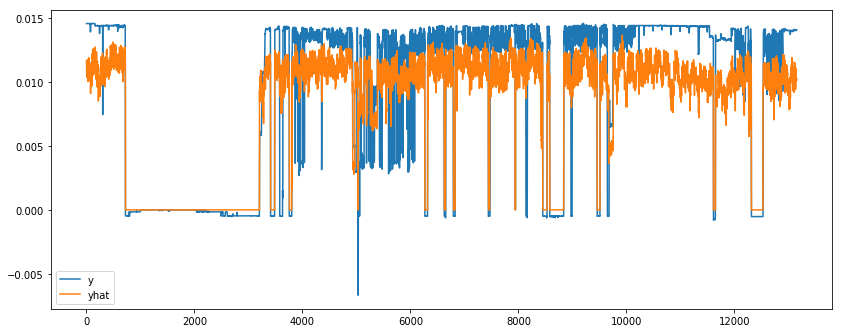

In [47]:
# take the first nuclear unit that i find
for colname in header_output_train:
    unit = colname.split('_')[1]
    if categ_input[unit]['techno'] == 'Nuclear':
        break
        
plt.plot(y[:,header_output_train.index('P_' + unit)], label='y')
plt.plot(yhat[:,header_output_train.index('P_' + unit)],label='yhat')
plt.legend()
plt.show()


# Implementing the metric


In [56]:
maxcapa = np.expand_dims(np.array([float(categ_input[header_output_train[el].split('_')[1]]['max capacity']) for el in orderunit_avail]),axis=0)

def div0(a, b):
    ''' ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0]'''
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
        c[ ~ np.isfinite( c )] = 0  # -inf inf NaN
    return c

def metric(yhat, y, categ_input):
    '''
    need to cope with the few units that have a maximal capacity of 0,
    which shouldnt bring out any issue when considering the metric because if the constraints are well taken care of,
    a max capa of 0 imply a production constant at 0
    '''
    return np.mean(div0((yhat-y),maxcapa)**2)
print(metric(yhat, y , categ_input))

0.257042742108


# Description of the underlying processes
## How is the level of production of a given unit chosen in the real world ?
### In practice
at time $t$

**Firstly**
* The demand for electricity is considered as being given : consumers decide to consume electricity for exogenous reasons, which do not depend on anything in the current problem
* The weather over France at a given hour entails a given level of renewable production (rain for hydro, cloud coverage for the solar production, wind speed for the wind production). This production is also considered as being exogenous.
* The interconnected countries call on France for exportations or importations. We consider here that this is exogenous. This is most debatable assumption about our inputs, in realitythe interconnexions are the outcome of an equilibrium between all the western european countries.

**Secondly** 
* The residual demand, that is the total demand, minus the renewables production, minus the interconnexions, has to be matched by the different units of production

**Thirdly**
* Given the levels of production **$q(t-1)$** at hour $t-1$, the overall demand is matched so as to minimise the aggregate cost of production of all the units called. Each unit $i$ can be thought as having three different types of costs : 
    * a marginal cost : $\alpha_i \cdot q_i(t)$
    * a dynamic cost : $\beta_i \cdot (q_i(t) - q_i(t-1))^2$
    * a turnoff/on cost : $\gamma_{i,on} \cdot \delta_{i,on} + \gamma_{i,off} \cdot \delta_{i,off}$, with $\gamma_{i,j}$ the cost for turning on or off unit $i$, and $delta_{i,j}$ a binary variable indicating whether the unit $i$turned on or off this hour.
* These costs are very much driven by the technology, although there are some variations for units of a given technology.
* This production has to verify the availability constraints.


This reasonning is described at the aggregate national level. However a unit is more likely to be called upon if the demand of its own region is high. That is because some electricity is lost when being transported on high voltage lines (about 8% on average), and these losses scale with the number of kms the electricity has to travel. Therefore, although a cheap unit might be available, if it far away from the centers of demand, it might in fact prove more expensive because of the losses incurred. 

### What you have to keep in mind 

The residual demand must be equal to the production only at the national level, there are always regional imbalances between production and demand. 

The above paragraph is a bit dense, but is here to convey information about the structure of the underlying processes, for the teams which would like to use this in their choice of models : brute-forcing ML algorithms is often less efficient than trying to take into account the underlying processes in the models. 


## Why do the input variables convey enough information to predict the output variables ?

At first glance, most of the information comes from the demand, renewables, and interconnexion time_series, which yield the residual demand and are much less numerous than the power units we are asking you to predict. 

However, the availability of the units conveys quite a lot of information. Secondly, there is quite a lot of correlation across units for a given technology : 


In [59]:
output_bytechno = {techno:[] for techno in set_techno}
for idx, varname in enumerate(header_output_train):
    unit = varname.split('_')[1]
    output_bytechno[categ_input[unit]['techno']].append(output_train[:,idx])
for techno in output_bytechno:
    output_bytechno[techno] = np.array(output_bytechno[techno])

# Take one techno   
one_tech = 'Natural gas'
print(output_bytechno[one_tech].shape)

#compute the correlation matrix
tech_cov = np.corrcoef(output_bytechno[one_tech])

# Generate a mask for the upper triangle
mask = np.zeros_like(tech_cov, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(tech_cov, mask=mask, cmap=cmap, vmax=1, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.show()

(22, 13152)


/Users/alexisberges/anaconda/envs/dev/lib/python3.5/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/alexisberges/anaconda/envs/dev/lib/python3.5/site-packages/numpy/lib/function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
